In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import labeling_network as lbln
from matplotlib import pyplot as plt
import theano
import theano.tensor as T
import numpy as np
from labeling_network import FullyConnectedLayer, ConvPoolLayer

Running with a CPU.  If this is not desired, then the modify network3.py to set
the GPU flag to True.


In [3]:
dataPath = '../../TrainingData/LabeledData-2015-09-07/'

In [4]:
train_data, valid_data, test_data = lbln.load_data_shared(
                     dataPath,
                     'capture',
                     dataPath + 'labels.dat',
                     n_train=8000,
                     n_validation=500,
                     n_test=100,
                     label_mask=3)

In [5]:
mini_batch_size = 10

In [6]:
network = lbln.Network([
#         ConvPoolLayer(image_shape=(mini_batch_size, 3, 64, 64), 
#                       filter_shape=(20, 3, 5, 5), 
#                       poolsize=(2, 2),
#                       activation_fn=lbln.ReLU),
        
#         ConvPoolLayer(image_shape=(mini_batch_size, 20, 30, 30), 
#                       filter_shape=(40, 20, 5, 5), 
#                       poolsize=(2, 2),
#                       activation_fn=lbln.ReLU),       
        
#         FullyConnectedLayer(n_in=13*13*40, 
#                             n_out=50, 
#                             activation_fn=lbln.ReLU,
#                             p_dropout=0.2),
        
#         FullyConnectedLayer(n_in=50, n_out=5)
        
        ConvPoolLayer(image_shape=(mini_batch_size, 3, 64, 64), 
                      filter_shape=(20, 3, 7, 7), 
                      poolsize=(2, 2),
                      activation_fn=lbln.ReLU),
        FullyConnectedLayer(n_in=29*29*20, n_out=128, p_dropout=0.5),
        FullyConnectedLayer(n_in=128, n_out=5)
        
        
    ], mini_batch_size)

In [7]:
network.SGD(train_data, 
            30, 
            mini_batch_size, 
            1.0, 
            valid_data, 
            test_data,
            "fire_classifier_best",
            learning_curve_file_name='fire_learning_curve'
           )

--- Training mini-batch number 0 ---
  Epoch 0: validation accuracy -0.054403
    This is the best validation accuracy to date.
      The corresponding test accuracy is -0.056769
    Current cost on training set: 0.0544313646646
--- Training mini-batch number 1000 ---
  Epoch 1: validation accuracy -0.053342
    This is the best validation accuracy to date.
      The corresponding test accuracy is -0.054112
    Current cost on training set: 0.0525763351893
--- Training mini-batch number 2000 ---
  Epoch 2: validation accuracy -0.052921
    This is the best validation accuracy to date.
      The corresponding test accuracy is -0.053141
    Current cost on training set: 0.0520544013232
--- Training mini-batch number 3000 ---
  Epoch 3: validation accuracy -0.052674
    This is the best validation accuracy to date.
      The corresponding test accuracy is -0.052193
    Current cost on training set: 0.0515536271781
  Epoch 4: validation accuracy -0.051045
    This is the best validation ac

/usr/lib/python2.7/dist-packages/numpy/core/_methods.py:55: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


#### Save network weights.

In [ ]:
network.save_as_file('fire_classifier')

In [8]:
import pylab
pylab.rcParams['figure.figsize'] = (6.0, 6.0)

In [9]:
def determine_test_accuracy(net, xs, ts, offset, allowed_dev):
    assert len(xs) == len(ts)
    errors = 0
    for x, t in zip(xs, ts):
        prediction = net.get_single_output(x)
        err = 1 - np.prod(np.greater(prediction - (t-offset)/allowed_dev, 0)) * np.prod(np.greater((t+offset)*allowed_dev - prediction, 0))
        errors += err
    return (1.0 * len(xs)-errors) / len(xs)

### Determine 'accuracy' on test set. 

In [10]:
print determine_test_accuracy(network, test_data[0].get_value(), test_data[1].get_value(), 0.2, 1.2)

0.89


In [11]:
test_data_xs = test_data[0].get_value()
test_data_ts = test_data[1].get_value()

valid_data_xs = valid_data[0].get_value()
valid_data_ts = valid_data[1].get_value()


### Determine all Losses on test images.

--- Worst predictions: ---
Target:     [ 0.  0.  0.  0.  0.]
Prediction: [ 0.00114177  0.00186745  0.05192341  0.80256231  0.80319375]
Loss:       0.258385460407


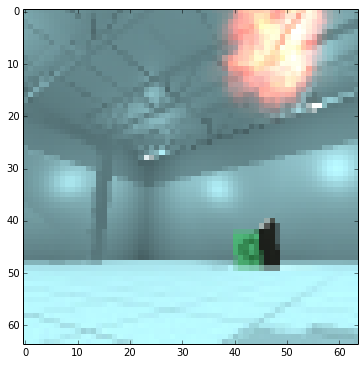

Target:     [ 0.  0.  0.  0.  0.]
Prediction: [ 0.43888409  0.33964425  0.22278987  0.33118533  0.25239448]
Loss:       0.106199895414


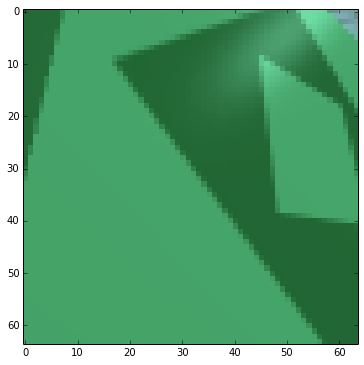

In [12]:
def print_classification(index):
    print 'Target:    ', classifications[index][1]
    print 'Prediction:', classifications[index][2]
    print 'Loss:      ', classifications[index][3]
    plt.imshow(classifications[index][0].reshape(64, 64, 3), interpolation='nearest')
    plt.show()


# Determine all errors on the test images
classifications = []
for x, t in zip(test_data_xs, test_data_ts):
    prediction = network.get_single_output(x)
    error = np.mean((t - prediction) ** 2)
    classifications.append((x, t, prediction, error))

print '--- Worst predictions: ---'
classifications = sorted(classifications, key = lambda (x, t, p, e): e, reverse=True)
print_classification(0)
print_classification(1)

### False positives / negatives.

--- FALSE POSITIVES ---
Target:     [ 0.  0.  0.  0.  0.]
Prediction: [ 0.00114177  0.00186745  0.05192341  0.80256231  0.80319375]
Loss:       0.258385460407


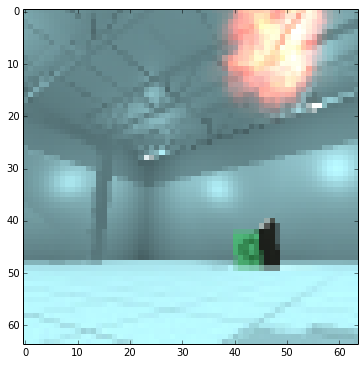

Target:     [ 0.  0.  0.  0.  0.]
Prediction: [ 0.43888409  0.33964425  0.22278987  0.33118533  0.25239448]
Loss:       0.106199895414


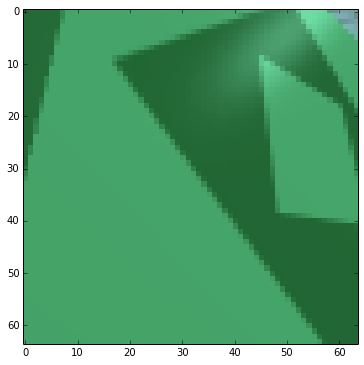





--- FALSE NEGATIVES ---
Target:     [ 0.8000001  1.         1.         1.         1.       ]
Prediction: [ 0.41458648  0.75916356  0.81359349  0.8743962   0.89029967]
Loss:       0.0538207417359


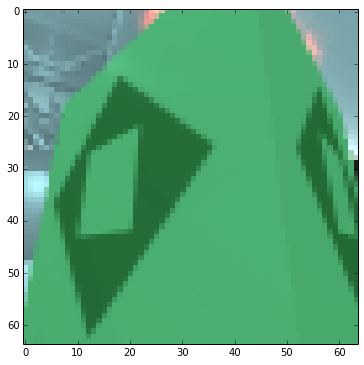

Target:     [ 0.         0.         0.9200001  1.         1.       ]
Prediction: [  1.67381804e-04   4.90531525e-03   6.53826117e-01   9.18635932e-01
   7.39238414e-01]
Loss:       0.0290978792072


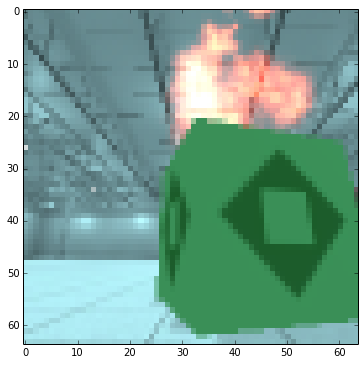

In [13]:
print '--- FALSE POSITIVES ---'
classifications = sorted(classifications, key = lambda (x, t, p, e): np.mean(p - t), reverse=True)
print_classification(0)
print_classification(1)


print '\n\n\n\n--- FALSE NEGATIVES ---'
classifications = sorted(classifications, key = lambda (x, t, p, e): np.mean(t - p), reverse=True)
print_classification(0)
print_classification(1)

### Find images displaying high signal w.r.t. target of interest.

In [ ]:
high_signal_images = np.asarray([(x, t) for (x, t) in zip(valid_data_xs, valid_data_ts) if np.mean(t) > 0.2])

print '%d high signal images:' % len(high_signal_images)

for x, t in high_signal_images[:10]:
    prediction = network.get_single_output(x)
    plt.imshow(x.reshape(64, 64, 3), interpolation='nearest')
    plt.show()
    print 't:', t
    print 'p:', prediction
    print 'd:', np.mean((t - prediction) ** 2)


### Determine baseline.

In [ ]:
## AVERAGE SQUARED MAGNITUDE OF SENSOR VALUES:

test_targets = train_data[1].get_value()
print 'Loss of mean-regressor: %f' % np.mean((test_targets - np.mean(test_targets)) ** 2)

### Visualize target labels

In [ ]:
import scipy.misc

def load_training_img(index):
    return scipy.misc.imread(dataPath + 'capture' + str(index).zfill(6) + '.png')[:,:,:-1]

def load_labeling_data(lower, upper):    
    labels = open(dataPath + 'labels.dat')
    lines = labels.readlines()[lower:upper]

    data = np.asarray([[float(d) for d in l.split(',')[:-1]] for l in lines])
    return data.reshape(upper-lower, 5, 5)

pic_ind = 5

img = load_training_img(pic_ind)

plt.imshow(img, interpolation='nearest')
plt.show()


data = load_labeling_data(pic_ind, pic_ind+1)
label_titles = ['Humanoid', 'PickupBox', 'Terminal', 'Fire', 'Walls']

for d, t in zip(data[0], label_titles):
    ax = plt.subplot()    
    ax.set_ylim(0, 1.1)
    ax.set_xlim(-2.5, 2.5)
    ax.set_title(t)
    barchart = ax.bar(np.arange(5) - 2, d, align='center')
    plt.show()
